# **Online optimization reproducibility challenge**

Implementation of Streaming sparse regression (SSR) algorithm, following the paper:

[Jacob Steinhardt, Stefan Wager, Percy Liang, The Statistics of Streaming Sparse Regression, arXiv, 2014](https://arxiv.org/abs/1412.4182)

We will compare results with SGD and projected SGD, our chosen baselines. 

Team members: Amaia Cardiel, Siqi Chen, Nicolas Hu

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, exp, inf
import time
import random
import cvxpy as cp
from tqdm.notebook import tqdm

## 0 - A few words on the theory of Streaming sparse regression (SSR)

* **Motivation**

The SSR algorithm was originally thought as a SGD adaptation to streaming and
sparse regression. Indeed, a streaming setting is special as it will provide almost no
memory and no time for the algorithm to work. SGD is known to be appropriate for a
streaming setting but is less so when such streaming setting is sparse. When dealing with
sparse data, a classic option is to use a LASSO method, that penalizes the l1 norm of a
weight vector in order to take into account sparsity (this approach is related to SGDproj).
The specificity of SSR is that it is suited for both a streaming and a sparse
setting. Indeed, it is adapted for streaming as it will take only O(d) time per data and
O(d) memory (with d the data dimension). It is also suited to sparse data as it will still
achieve the same convergence rate as the classic LASSO approach (in the batch offline
setting). Another SSR’s quality is that the algorithm is rather simple in its design, with
iterative steps of gradient computation, averaging and soft-thresholding. Finally, let us
note that the paper mentions the fact that SSR’s path will look like a Brownian motion
while LASSO moves in straighter lines. As for the drawback the authors of the article
specify that sparsified versions of SGD usually reaches weaker worst-case guarantees.

## 1 - Preliminary code

**Loading the data**

In [2]:
# If one uses Google Colab
if get_ipython().__class__.__module__ == "google.colab._shell":
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/Colab Notebooks/oco/'

# Without Colab: 
# one should put the mnist csv files in a folder named 'data' next to this notebook
else:
    import os
    path = os.getcwd() + '/data/'

In [3]:
# Loading the entire files using Pandas
df = pd.read_csv(path+'mnist_train.csv', header=None)
df2 = pd.read_csv(path+'mnist_test.csv', header=None)

# Making the data into numpy arrays 
Train_Data, Test_Data = df.to_numpy(), df2.to_numpy()

In [4]:
print("Dimensions des données:", np.shape(Train_Data), np.shape(Test_Data))

Dimensions des données: (60000, 785) (10000, 785)


**Data preparation**

In [4]:
# We save the labels (1st column) appart
Train_Label, Test_Label = Train_Data[:,0], Test_Data[:,0]

# Set the labels to 1 if original_label==0, -1 otherwise
Train_Label=2*(Train_Label==0)-1
Test_Label=2*(Test_Label==0)-1

In [6]:
print("Dimensions des labels:", np.shape(Train_Label), np.shape(Test_Label))

Dimensions des labels: (60000,) (10000,)


In [5]:
# We normalize the pixels data by 255
Train_Data, Test_Data = Train_Data/255, Test_Data/255

# We erase the 1st column of labels and replace it by an intercept (made of ones)
Train_Data[:,0], Test_Data[:,0] = np.ones(len(Train_Data)), np.ones(len(Test_Data))

**Computing the sparsity of MNIST**

In [8]:
# We compute the number of 0 values for each image in the train (or test) set
Nb_0_per_image_train = np.sum(Train_Data==0,axis=1)
Nb_0_per_image_test = np.sum(Test_Data==0,axis=1)

# We then compute the mean number of 0 values for all of our train (or test) images
Mean_Train, Mean_Test = np.mean(Nb_0_per_image_train), np.mean(Nb_0_per_image_test)
print("Mean number of 0 values per image in the Train set:", Mean_Train, "over a total of 785 entries")
print("Mean number of 0 values per image in the Test set:", Mean_Test, "over a total of 785 entries")

Mean number of 0 values per image in the Train set: 634.0974 over a total of 785 entries
Mean number of 0 values per image in the Test set: 632.8781 over a total of 785 entries


<a name="aux_func"></a>
**Auxiliary functions**

In [6]:
def hinge_loss(a,b,x, lambda_reg=None):
    '''
    Inputs:
    a: data (pixels) matrix of dim (n,785)
    b: label vector of dim (n,)
    x: param vector of dim (785,)
    lambda_reg: Regularization parameter. If set to None, we get the unregularized hinge loss

    Output:
    hinge: The value of the hinge loss (with or without regularization)
    '''
    hinge = 1-b*(a@x) # vectorized computation
    hinge[hinge<0] = 0 # taking the max between each entry and 0
    hinge = np.mean(hinge)
    
    # Adding a regularization term (optional)
    if lambda_reg != None:
        hinge += lambda_reg*(np.linalg.norm(x))**2/2
        
    return hinge

In [7]:
def grad_hinge_loss(a,b,x, lambda_reg=None):
    '''
    Inputs:
    a: data (pixels) matrix of dim (n,785)
    b: label vector of dim (n,)
    x: param vector of dim (785,)
    lambda_reg: Regularization parameter. If set to None, we get the unregularized hinge loss

    Output:
    Grad_hinge: The value of the gradient of the hinge loss (with or without regularization)
    '''
    n=len(a)
    threshold = 1 - b*(a@x)
    grad = -(a.T*b).T # dim (n,785)
    grad[threshold<0]=0
    grad=np.mean(grad,axis=0) # dim (785,)

    # Adding a regularization term (optional)
    if lambda_reg != None:
        grad += lambda_reg*x
        
    return grad # dim (785,)

In [8]:
def instgradreg(a,b,x, lambda_reg=None): 
    '''
    Inputs:
    a: sampled training data of dim (785,)
    b: label associated with a
    x: param vector of dim (785,)
    lambda_reg: Regularization parameter. If set to None, we get the unregularized hinge loss

    Output:
    Grad_hinge: The value of the gradient of the hinge loss (with or without regularization) on one sampled data
    '''
    threshold = 1 - b*(a@x)
    grad = -a*b 
    grad[threshold<0]=0
    
    # Adding a regularization term (optional)
    if lambda_reg != None:
        grad += lambda_reg*x
        
    return grad # dim (785,)

In [9]:
# Projection of a vector v with non-negative coordinates on the simplex of radius z

def pisimplex(v,z=1):
    if np.sum(v)==1:
        return v
    else:
        d=len(v)
        u=np.sort(v)[::-1] # sort in decreasing order
        su=np.cumsum(u) 
        sum_to_test=su-np.arange(1,d+1)*u
        d0=np.max(np.array([index for index,value in enumerate(sum_to_test) if value <z]))
        theta=(su[d0]-z)/(d0+1) 
        
        #softthreshold
        result=v-theta
        result[result<0]=0
        return result

In [18]:
# Projection on the l1-ball

def pib1(x,z=1):
    v=np.abs(x)
    if np.sum(v)>z:
        print('project')
        u=pisimplex(v,z)
        print("sum u:", np.sum(u))
        x=np.sign(x)*u 
    return x

**Useful functions for plotting graphs**

In [17]:
# Compute the percentage of test data that were well predicted 
# thanks to learnt parameters 'param' on the train set
# We will compute error rates with: 1-rate(param,c)

def rate(param,c):
    """
    Inputs:
    c: test data, dim = 10000*785
    param: x retuned by an algorithm, dim = (iters+1)*785

    Output:
    Percentage of test data that were well predicted
    """
    pred = c@param.T # dim=10000*101
    Test_Label_reshape = np.expand_dims(Test_Label, axis=1) #dim=10000*1
    correct = (pred*Test_Label_reshape>0) # dim=10000*101
    return np.mean(correct, axis=0) # len=101

In [19]:
# We will mostly produce graphs drawn with this function

def plot_rates_iters_e4(rate_list, legend_list):
    axex = np.arange(100,10100,100)
    axex = axex.tolist()
    axex.insert(0,1)
    plt.figure(figsize=(5,5))
    for i in range(len(legend_list)):
        plt.plot(axex, rate_list[i], label=legend_list[i])
    plt.title('Comparison of the test error')
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

## 2 - Implementing Stochastic Gradient Descent (baseline)

This 2nd section's code was implemented in Python following the R code provided by our supervisor, Olivier Wintenberger (Professor at Sorbonne Université).  

#### **1) Unconstrained SGD**

In [23]:
def SGD(a, b, loss, grad, eta, iters=100, init=None, projK=None, lambda_reg=None, LR_Lambda=None,z=0):
    # Sample index uniformly
    ind = np.random.choice(len(b),iters)
    a = a[ind]
    b = b[ind]
    
    # Initialization of init if not given
    if init==None:
        x=np.zeros(np.shape(a)[1]) # dim (785,)
    else:
        x= init

    # Return the mean of x    
    m = x 
    
    # Initialization of parameters matrix
    params = np.zeros((101, np.shape(a)[1])) 
    params[0]= x 
    j = 1
    Loss_list =[loss(a,b,x,lambda_reg)] 
    #print("Iteration: 0 | loss:", Loss_list[-1])
    
    for i in tqdm(range(1,iters+1)):
        #if i%1000==0:
        #    print("Iteration:",i, " | loss:", Loss_list[-1])
            
        # computing eta
        if LR_Lambda!=None:
            eta = 1/ (LR_Lambda *i)
                
        # Updating y
        y=x-eta*grad(a[i-1,], b[i-1], x, lambda_reg)
        
        # Projecting y 
        if projK == None:
            x=y
        else:
            x=projK(y,z=z)
        
        # Return the mean of x
        m = ((i-1)*m + x)/i
        # Updating params matrix
        if i%(iters/100) ==0:
            params[j]=m
            # Keeping track of the current loss
            Loss_list.append(loss(a,b,m,lambda_reg))
            j = j+1

    return m, Loss_list, params 

In [24]:
np.random.seed(100)

# Run and time the algorithm
nb_iter = 10000
st_SGD = time.time()
x_mean_SGD, Loss_list_SGD, params_SGD = SGD(a=Train_Data, b=Train_Label, iters=nb_iter, loss=hinge_loss, grad=instgradreg, eta=0.001,lambda_reg=1/3, LR_Lambda=1/3)
et_SGD = time.time()
print("\n Runtime of unscontrained SGD for iters=",nb_iter,":",et_SGD-st_SGD)

# Compute the error rate on the test set
error_SGD = 1-rate(params_SGD,Test_Data)

  0%|          | 0/10000 [00:00<?, ?it/s]


 Runtime of unscontrained SGD for iters= 10000 : 3.8446877002716064


run time of SGD for iters= 10000 : 1.32s

error of SGD after 10000 iters : 0.02

#### **2) Projected SGD**

In [25]:
np.random.seed(100)

# Run and time the algorithm
nb_iter = 10000
st_SGDproj = time.time()
x_mean_SGDproj, Loss_list_SGDproj, params_SGDproj = SGD(a=Train_Data, b=Train_Label, iters=nb_iter, loss=hinge_loss, grad=instgradreg, projK=pib1, eta=0.001,lambda_reg=1/3, LR_Lambda=1/3, z=100)
et_SGDproj = time.time()
print("\n Runtime of SGDproj for iters=",nb_iter,":",et_SGDproj-st_SGDproj)

# Compute the error rate on the test set
error_SGDproj = 1-rate(params_SGDproj,Test_Data)

  0%|          | 0/10000 [00:00<?, ?it/s]


 Runtime of SGDproj for iters= 10000 : 6.720916748046875


run time of SGDproj for iters= 10000 : 1.61s

error of SGDproj after 10000 iterations : 0.02

#### **3) Let us compare SGD and SGDproj**

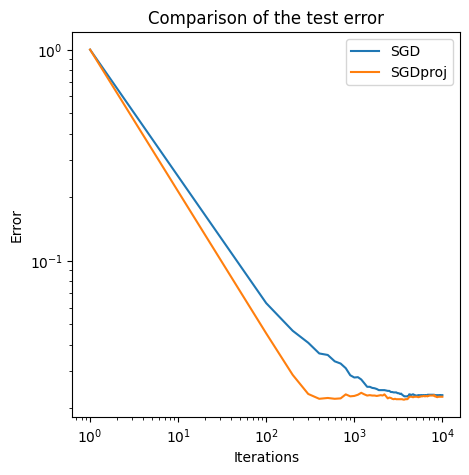

In [26]:
plot_rates_iters_e4(np.vstack((error_SGD,error_SGDproj)), ["SGD","SGDproj"])

## 3 - Implementing Streaming sparse regression (SSR) algorithm

We implemented from scratch the two versions of the SSR algorithm, as proposed by our [reference article](https://arxiv.org/abs/1412.4182). 

#### **1) Algorithm 1: Streaming sparse regression (SSR)**

In [48]:
# Function for the soft_thresholding operator

def S(Lambda, x):
    x_abs = np.abs(x)
    zero_indices=(x_abs<Lambda)
    x_abs=x-Lambda*np.sign(x)
    x_abs[zero_indices]=0
    return x_abs

In [49]:
# Algorithm 1: Streaming sparse regression (SSR)

# Remark: x in our code is the same as w (the parameter estimate) in the article

def SSR(Lambda, eta, epsilon, lambda_reg=0, a=Train_Data, b=Train_Label, loss=hinge_loss, grad=instgradreg, S=S,iters=10000, init=None):
    '''
    Inputs:
    Lambda: parameter used to compute the threasholding values
    lambda_reg: parameter used to regularize the gradient computation
    eta, epsilon: two real numbers used in the sparsification step computation
    S: the soft-thresholding function
    '''
    
    # Sample index uniformly
    ind = np.random.choice(len(b),iters)
    a = a[ind]
    b = b[ind]
    d= np.shape(a)[1]
    
    # Initialization of init if not given
    if init==None:
        x=np.zeros(d) # dim (785,)
    else:
        x= init

    # Initialization of theta 
    theta = np.zeros(d)
    # m=x # m is the mean of x (for test purposes)

    # To compute the gradient norms (but it slows the algorithm)
    # max_grad_norm=0
    
    # Initialization of parameters matrix
    params = np.zeros((101, np.shape(a)[1])) 

    params[0]= x 
    j = 1
    Loss_list =[loss(a,b,x,lambda_reg)] 
    #print("Iteration: 0 | loss:", Loss_list[-1])
    
    for i in tqdm(range(1,iters+1)):
        #if i%1000==0:
        #    print("Iteration:",i, " | loss:", Loss_list[-1])
            
        # computing lamba_t, the thresholding value
        Lambda_t = Lambda*sqrt(i+1)
        
        # sparsification step
        x=(1/(epsilon+eta*(i-1)))*S(Lambda_t,theta)
        
        # gradient step 
        theta = theta -(grad(a[i-1,], b[i-1], x, lambda_reg)-eta*x)
        
        # To compute the gradient norms
        '''
        current_norm=np.max(np.abs(grad(a[i-1,], b[i-1], x, lambda_reg)))
        if current_norm>max_grad_norm:
            max_grad_norm=current_norm
        '''
        # Get the mean of x (for test purposes)
        # m = ((i-1)*m + x)/i 

        # Updating params matrix
        if i%100 ==0:
            params[j]=x
            # Keeping track of the current loss
            Loss_list.append(loss(a,b,x,lambda_reg))
            j = j+1
            
    return x, Loss_list, params #, max_grad_norm

In [50]:
np.random.seed(100)

alpha=1/12

# Run and time the algorithm
nb_iter=10000
st_SSR = time.time()
x_SSR, Loss_list_SSR, params_SSR = SSR(Lambda=0.35, eta=alpha/2, epsilon=0.00001, lambda_reg=alpha, iters=nb_iter)
et_SSR = time.time()
print("\n Runtime of SSR for iters=",nb_iter,":",et_SSR-st_SSR)

# Compute the error rate on the test set
error_SSR = 1-rate(params_SSR,Test_Data)

  0%|          | 0/10000 [00:00<?, ?it/s]


 Runtime of SSR for iters= 10000 : 4.631010293960571


run time of SSR for iters= 10000 : 1.49s

Maximum gradient norm: 1.2372107652572792

#### **2) Algorithm 2: SSR with averaging**

In [52]:
# Algorithm 2: Streaming sparse regression with averaging (SSR_A)

def SSR_A(Lambda, eta, epsilon, lambda_reg=0, a=Train_Data, b=Train_Label, loss=hinge_loss, grad=instgradreg, S=S,iters=10000, init=None):
    '''
    Inputs:
    Lambda: parameter used to compute the threasholding values
    lambda_reg: parameter used to regularize the gradient computation
    eta, epsilon: two real numbers used in the sparsification step computation
    S: the soft-thresholding function
    '''
    
    # Sample index uniformly
    ind = np.random.choice(len(b),iters)
    a = a[ind]
    b = b[ind]
    d= np.shape(a)[1]
    
    # Initialization of init if not given
    if init==None:
        x=np.zeros(d) # dim (785,)
    else:
        x= init

    # Initialization of theta and w_hat (sort of average of x) 
    theta = np.zeros(d)
    w_hat = np.zeros(d)

    # To compute the gradient norms (but it slows the algorithm)
    # max_grad_norm=0

    # Initialization of parameters matrix
    params = np.zeros((101, np.shape(a)[1])) 
    params[0]= w_hat
    j = 1
    Loss_list =[loss(a,b,w_hat,lambda_reg)] 
    #print("Iteration: 0 | loss:", Loss_list[-1])
    
    for i in tqdm(range(1,iters+1)):
        #if i%1000==0:
        #    print("Iteration:",i, " | loss:", Loss_list[-1])
            
        # computing lamba_t, the thresholding value
        Lambda_t = Lambda*((i)**1.5)
        
        # sparsification step
        x=(1/(epsilon+eta*i*(i-1)/2))*S(Lambda_t,theta)
        
        # gradient step 
        theta = theta -i*(grad(a[i-1,], b[i-1], x, lambda_reg)-eta*x)
        
        # averaging step
        w_hat = (1-2/(i+1))*w_hat+2*x/(i+1)
        
        # To compute the gradient norms
        '''
        current_norm=np.max(np.abs(grad(a[i-1,], b[i-1], x, lambda_reg)))
        if current_norm>max_grad_norm:
            max_grad_norm=current_norm
        '''

        # Updating params matrix
        if i%100 ==0:
            params[j]=w_hat
            # Keeping track of the current loss
            Loss_list.append(loss(a,b,w_hat,lambda_reg))
            j = j+1
            
    return w_hat, Loss_list, params #, max_grad_norm

In [53]:
np.random.seed(100)

alpha=1/20

# Run and time the algorithm
nb_iter=10000
st_SSR_A = time.time()
w_hat_SSR_A, Loss_list_SSR_A, params_SSR_A = SSR_A(Lambda=0.35, eta=alpha/2, epsilon=0.00001, lambda_reg=alpha, iters=nb_iter)
et_SSR_A = time.time()
print("\n Runtime of SSR_A for iters=",nb_iter,":",et_SSR_A-st_SSR_A)

# Compute the error rate on the test set
error_SSR_A = 1-rate(params_SSR_A,Test_Data)

  0%|          | 0/10000 [00:00<?, ?it/s]


 Runtime of SSR_A for iters= 10000 : 6.401726961135864


run time of SSR_A for iters= 10000 : 1.66s

Maximum gradient norm: 1.381122595197087

#### **3) Graphical comparison of the two versions of SSR**

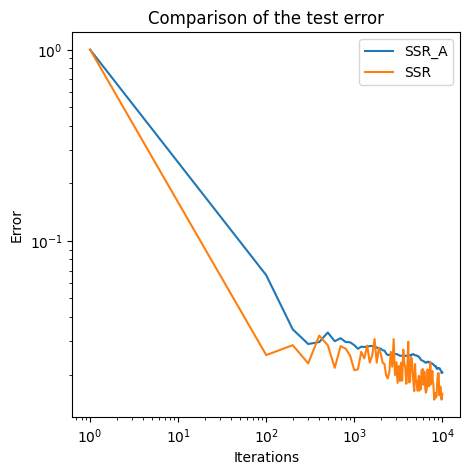

In [54]:
# Compare SSR and SSR_A
plot_rates_iters_e4([error_SSR_A, error_SSR], ["SSR_A", "SSR"])

## 4 - Graphical comparison between SSR and chosen baseline


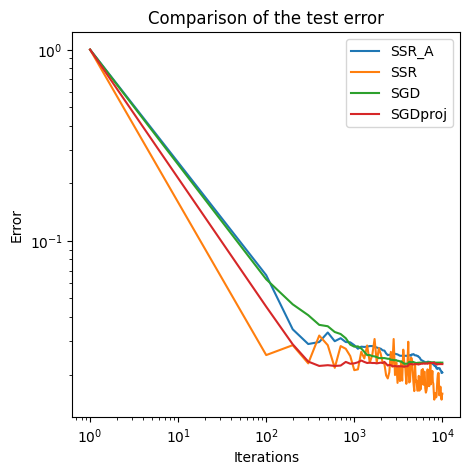

In [55]:
# Compare SSR, SSR_A and SGD algorithms
plot_rates_iters_e4(np.vstack((error_SSR_A, error_SSR, error_SGD, error_SGDproj)), ["SSR_A","SSR","SGD", "SGDproj"])

The latter figure shows the differences between our two SSR algorithms and our two versions of SGD (original and projected). This comparison is particularly interesting as SSR can be seen as an adaptation of SGD that takes into account sparsity, which is also what does the projected version of SGD. The error rate of SSR is almost always the lowest and the limit towards which both SSR and SSR_A seem to be converging (SSR: 0.013, SSR_A: 0.015) appears to be lower than the SGD and SGDproj limits (≈ 0.022). As for the running time, the four algorithms seem to be very close with results ranging between 1.32 and 1.66 seconds for 10,000 iterations. Moreover, SSR_A, theoretically close to SGDproj, has almost exactly the same runtime $\frac{1.66}{1.61}$ ≈ 1.

## 5 - Comments on found results

In order to better appreciate the SSR results (heavily based on sparsity of the data and
α strong convexity of the loss), we decided to check whether the assumptions hold in our
MNIST experimental setting.

* **Sparsity**

As shown in Section 1, 80% of the pixels of each image have 0 values in average. It seems therefore fitting to be applying our SSR algorithm to MNIST as the sparsity
requirement is met.

* **α strong convexity of the loss**

We used the hinge loss with regularization for this algorithm. Indeed, the hinge
loss is not strongly convex but only convex. Therefore adding a regularization term ($\frac{lambda_reg}{2} \times ||x||^2$) that is strongly convex enabled us to have indeed a α strongly convex loss function, with α = lambda_reg.

* **Choice of hyperparameters**

We first had to choose a value for α. We tried various values and saw that SSR and SSR_A’s performances were much better with smaller α values. In the end we found that λ = $\frac{1}{12}$ seemed to be quite optimal for SSR as well as λ = $\frac{1}{20}$ for SSR_A.

We then decided to follow the guidelines of Theorems 2.1 and 2.2 from the article
regarding the choice of the other hyperparameters, hence we set η = $\frac{α}{2}$ . We could not set
ϵ to 0 as recommended because this would lead to a division by 0 at iteration 1. We thus
chose a very small value and set ϵ = 0.00001.

Finally, for the choice of the soft-threshold λ we found quite difficult to follow the
assumptions from the theorem as we did not know B - the theoretical bound of gradients’
norms - nor the optimal δ value that one should use in practice. We thus fixed all the
other hyperparameters and tried a few values of λ. The best value that we could find (in
terms of lower final error rate on MNIST test set) was λ = 0.35.

* **Comments on the results obtained**

First, the paper stated that SSR’s path would look like a Brownian motion while
LASSO moves in straighter lines. This is exactly what was shown in the last Figure, as the SSR was displaying Brownian-like fluctuations, especially after iteration
n°500, while SGDproj (related to LASSO) was much straighter in its motion. As expected
SSR_A, that benefits from additional averaging, is much smoother than SSR.

Furthermore, the runtime monitoring showed that SSR and SSR_A were as fast as our baselines, with SSR being a bit faster (1.49s to perform 10,000 iterations) than its baseline counterpart SGDproj (1.61s). This tends to prove that the proposed algorithms are indeed fitted for a streaming setting. 

SSR algorithms were also reaching lower error rates than SGD and even SGDproj which tends
to confirm the theoretical added value of our reference article.

* **About the α value**

If we had chosen a bigger α value for SSR_A (say α = $\frac{1}{3}$ instead of α = $\frac{1}{20}$), the
theoretical bound from the article would have become much smaller: $|| ŵ_T − w^∗ ||_2^2 ≈ 1.77$ instead of $78.5$ (in magnitude). Empirically however, we found the opposite: the smaller the α, the lower the error rates,
especially as T grows, for both SSR algorithms. This led us to choose smaller α in practice, though they led to much higher regret and parameter error bounds in theory.

* **Concluding remarks**

As a conclusion, we can thus say that the proposed algorithms of our article did bring
interesting novelties and a refinement to SGD and SGDproj that indeed performed a bit
better (at least on sparse data such as MNIST) and was fast enough to be used in a
streaming setting. We found however a difference with the theory of the article, that
showed that the regret and error bounds were inversely correlated to the chosen α value
(the smaller the α the bigger the regret and parameter error bounds), while we found an
empirical positive correlation (the smaller the α the smaller the error on our MNIST test set).